In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy
from uncertainties.umath import exp

In [3]:
def gauss(x, A, mu, sig):
    return A*np.exp(-((x-mu)/sig)**2)

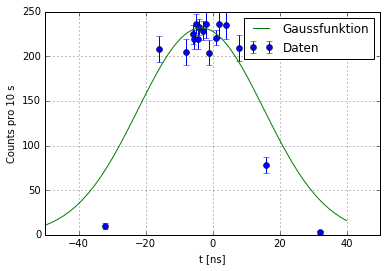

[ 231.88505911   -3.45568813   26.55605803] [[ 6.42281263         nan         nan]
 [        nan  1.42262657         nan]
 [        nan         nan  3.53393067]]


,t,counts,messzeit,count10,std_c,std_c10
0,-32.0,10,10.0,10.000000,3.162278,3.162278
1,-16.0,208,10.0,208.000000,14.422205,14.422205
2,-8.0,205,10.0,205.000000,14.317821,14.317821
3,-6.0,449,20.0,224.500000,21.189620,10.594810
4,-5.5,438,20.0,219.000000,20.928450,10.464225
5,-5.0,473,20.0,236.500000,21.748563,10.874282
6,-4.5,438,20.0,219.000000,20.928450,10.464225
7,-4.0,698,30.0,232.666667,26.419690,8.806563
8,-3.0,457,20.0,228.500000,21.377558,10.688779
9,-2.0,236,10.0,236.000000,15.362291,15.362291


In [23]:
df = pd.read_csv('../daten/zeit.dat', header=0, names=['t','counts','messzeit'], skipinitialspace=True)
df.fillna(10, inplace=True)
df['count10'] = df.counts / df.messzeit*10
df['std_c'] = np.sqrt(df['counts'])
df['std_c10'] = df['std_c']/df.messzeit*10


popt1, pcov1 = curve_fit(gauss, df.t.values, df.count10.values, sigma=1/df.std_c10)

x = np.linspace(-50, 40, 50)
y = gauss(x, popt1[0], popt1[1], popt1[2])

#print(popt,pcov)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df['t'].values, y=df['count10'].values, yerr=df.std_c10.values, label='Daten', linestyle='None', marker='o')
ax.plot(x,y, label='Gaussfunktion')
ax.grid()
ax.set_xlim((-50,50))
ax.set_ylim((0,250))
ax.set_xlabel('t [ns]')
ax.set_ylabel('Counts pro 10 s')
ax.legend(loc='upper right')
plt.savefig('../tex/Bilder/koinzidenz.pdf')
plt.show()
print(popt1,np.sqrt(pcov1))
df
#df.to_latex('Koinzidenz.dat', column_format='lcc', index=False, float_format=lambda x : str(round(x,1)), columns=['t', 'messzeit','counts','std_c', 'count10','std_c10'])

In [5]:
df2 = pd.read_csv('../daten/kalibration.Spe', comment='#', skipinitialspace=True, header=None, names=['count'])
df2 = df2[(df2['count'].values != 0)]
df2['channel'] = df2.index.values

# meld channels that lie next to each other
channelList = list()
countList = list()
errList = list()
tempChannelList = list()
tempCountList = list()

def mergeList(l1, l2):
    totCount = np.sum(l2)
    meanChan = np.average(l1, weights=l2)
    std = np.sqrt(np.average((l1-meanChan)**2, weights=l2))
    return meanChan, totCount, std

for i in df2.iterrows():
    # wenn Liste noch leer, erzeuge ersten Eintrag
    if not tempChannelList:
        tempChannelList.append(i[0])
        tempCountList.append(i[1]['count'])
    else:
        # wenn Liste nicht leer und vorheriger Channel ist in der Liste
        if i[0]-1 in tempChannelList:
            tempChannelList.append(i[0])
            tempCountList.append(i[1]['count'])
        else:
            # Aktueller wert gehört zu neuem Channel -> merge alle alten und erzeuge neue leere liste
            chann, count, err = mergeList(tempChannelList, tempCountList)
            tempChannelList = list()
            tempCountList = list()
            channelList.append(chann)
            countList.append(count)
            errList.append(err)
            tempChannelList.append(i[0])
            tempCountList.append(i[1]['count'])
chann, count, err = mergeList(tempChannelList, tempCountList)
channelList.append(chann)
countList.append(count)
errList.append(err)
df3 = pd.DataFrame({'counts' : countList, 'channel' : channelList, 'error':errList, 'deltaT' : [1,2,3,4,5,6,7,8,9]})

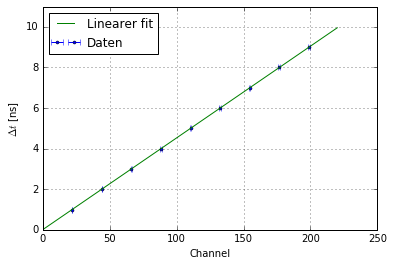

(0.045240299772403396+/-1.2361790891978633e-07,
 0.0034321530446440275+/-0.00014100976295846945)

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df3['channel'], y=df3['deltaT'], xerr=df3['error'], label='Daten', ms=3, marker='o', linestyle='None')
ax.grid()
ax.set_xlabel('Channel')
ax.set_ylabel(r'$\Delta t$ [ns]')

def lin(x, m, b):
    return m*x+b

popt2, pcov2 = curve_fit(lin, df3.deltaT.values, df3.channel.values, sigma=1/df3.error.values)
m = 1/ufloat(popt2[0],pcov2[0,0])
b = -ufloat(popt2[1],pcov2[1,1])*m

x = np.linspace(0, 220, 5)
y = lin(x, m.nominal_value, b.nominal_value)
ax.plot(x,y, label='Linearer fit')
ax.legend(loc='best')
ax.set_xlim((0,250))
ax.set_ylim((0,11))

plt.savefig('../tex/Bilder/linFit.pdf')
plt.show()
popt2,pcov2
m,b
#df3.to_latex('LinFit.dat', column_format='lcc', index=False, float_format=lambda x : str(round(x,2)))

In [53]:
# Poisson
N = ufloat(7894976, np.sqrt(7894976))
N_quer = N / 246420
P_n1 = (N_quer*15*10**-6)*exp(-(N_quer*15*10**-6))
N_b = P_n1*N

# Channel limit
x = 12.5
y = 1/m*x-b/m
N_b/y

13.729127656384316+/-0.00977126868506257

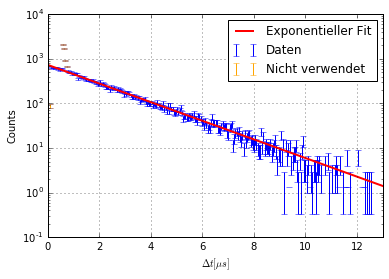

(array([ 729.57503377,   -2.08302944]), array([[ 4.15425578,  0.21693126],
        [ 0.21693126,  0.0151733 ]]))

In [7]:
def exp(x, A, b):
    return A*np.exp(x/b)

df4 = pd.read_csv('../daten/daten.Spe', comment='#', skipinitialspace=True, header=None, names=['count'])
df4['count'] = df4['count'] - 7.41 #Background
df4['channel'] = df4.index.values
df4['deltaT'] = lin(df4.channel, popt2[0], popt2[1])
df4.query('count > 0', inplace=True)

df4Fit = df4.query('(channel< 13 | channel>16) & channel > 2')
df4NoFit = df4.query('13 <= channel <=16 | channel <3')
popt3, pcov3 = curve_fit(exp, df4Fit.deltaT, df4Fit['count'], p0=[500,-0.2])
x = np.linspace(0, 15, 100)
y = exp(x, popt3[0], popt3[1])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df4['deltaT'], y=df4['count'], yerr=np.sqrt(df4['count'].values), label='Daten', linestyle='None')
ax.errorbar(x=df4NoFit['deltaT'], y=df4NoFit['count'], yerr=np.sqrt(df4NoFit['count'].values), label='Nicht verwendet', color='orange', linestyle='None')
ax.plot(x,y, c='red',lw=2, label='Exponentieller Fit')
ax.grid()
ax.legend()
ax.set_ylabel('Counts')
ax.set_xlabel(r'$\Delta t [\mu s]$')
ax.set_xlim((0,13))
ax.semilogy()
plt.savefig('../tex/Bilder/lebensdauer.pdf')
plt.show()
popt3,np.sqrt(pcov3)

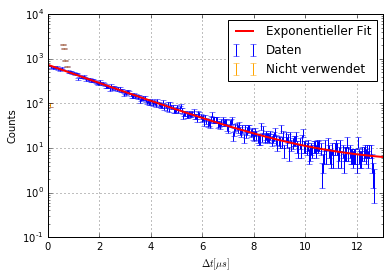

(array([ 729.3399655 ,   -2.11249962,    4.77961491]),
 array([[ 3.88228609,  0.2109649 ,  0.49804078],
        [ 0.2109649 ,  0.01930422,  0.11795737],
        [ 0.49804078,  0.11795737,  1.07892109]]))

In [8]:
def exp2(x, A, b, c):
    return A*np.exp(x/b)+c

df5 = pd.read_csv('../daten/daten.Spe', comment='#', skipinitialspace=True, header=None, names=['count'])
df5['channel'] = df5.index.values
df5['deltaT'] = lin(df5.channel, popt2[0], popt2[1])
df5.query('count > 0', inplace=True)

df5Fit = df5.query('(channel< 13 | channel>16) & channel > 2')
df5NoFit = df5.query('13 <= channel <=16 | channel <3')
popt4, pcov4 = curve_fit(exp2, df5Fit.deltaT, df5Fit['count'], p0=[500,-0.2,0])
x = np.linspace(0, 15, 100)
y = exp2(x, popt4[0], popt4[1],popt4[2])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x=df5['deltaT'], y=df5['count'], yerr=np.sqrt(df5['count'].values), label='Daten', linestyle='None')
ax.errorbar(x=df5NoFit['deltaT'], y=df5NoFit['count'], yerr=np.sqrt(df5NoFit['count'].values), label='Nicht verwendet', color='orange', linestyle='None')
ax.plot(x,y, c='red',lw=2, label='Exponentieller Fit')
ax.grid()
ax.legend()
ax.set_ylabel('Counts')
ax.set_xlabel(r'$\Delta t [\mu s]$')
ax.set_xlim((0,13))
ax.semilogy()
plt.savefig('../tex/Bilder/lebensdauer_fit.pdf')
plt.show()
popt4,np.sqrt(pcov4)